<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reservoir Computing Assignment

This assignment involves predicting time series data using the Lorenz system and reservoir computing, a type of recurrent neural network. Follow the steps outlined below to complete your tasks.

## Task 1: Generate Training Set

1. **Generate a training set of time series `x2(t)` by numerically solving Equation (4), with parameters:**
   - $ \sigma = 10 $
   - $ r = 28 $
   - $ b = \frac{8}{3} $

Reference for the task: Exercise 3.2 in *Nonlinear Time Series Analysis* by Kantz and Schreiber.

## Task 2: Setup and Train Reservoir

2. **Set up a reservoir as described in Equation (1) and train the output weights to minimize the energy function when predicting the Lorenz system.**

$$
r_i(t+1) = g\left( \sum_{j=1} w_{ij} r_j(t) + \sum_{k=1}^{N} w_{ik}^{(in)} x_k(t) \right)
$$

$$
O_i(t+1) = \sum_{j=1}^{M} w_{ij}^{(out)} r_j(t+1)
$$


## Task 3: Train and Evaluate Two Reservoirs

3. **Train two reservoirs:**
   - One on the entire Lorenz system. $\sigma$
   - One on a single variable of the Lorenz system, say `x2`. For the single variable reservoir, only predict that variable.

   **Evaluate their prediction performance over a range of different values for the maximal singular value of the reservoir weight matrix `W`. Determine the upper and lower bounds of singular values that allow the reservoir to predict the time series in both cases.**

   **Discuss:**
   - The bounds observed.
   - Differences between the two cases.
   - Why these differences might appear.

   **Hint:** Plot the prediction performance versus the maximal singular value using a log-scale for the x-axis.

## Task 4: Evaluate Prediction Performance

4. **Evaluate how well the reservoir computer predicts the time series `x2(t)` and compare with standard methods.**
   - Determine the maximal Lyapunov exponent $ \lambda_1 $ by numerical simulation of Eq. (4) of the Lorenz system.
   - Check for how many Lyapunov times the time-series prediction works.
   - Plot the prediction error as a function of $ t\lambda_1 $.


In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from numpy import tanh, random
from numpy.linalg import eigvals

In [7]:
# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x1, x2, x3 = y
    return [-sigma * (x1 - x2), x1 * (rho - x3) - x2, x1 * x2 - beta * x3]

# Initial conditions and time span
y0 = [1.0, 1.0, 1.0]
t_span = [0, 200]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solving the system
sol = solve_ivp(lorenz_system, t_span, y0, t_eval=t_eval)
x2 = sol.y[1]



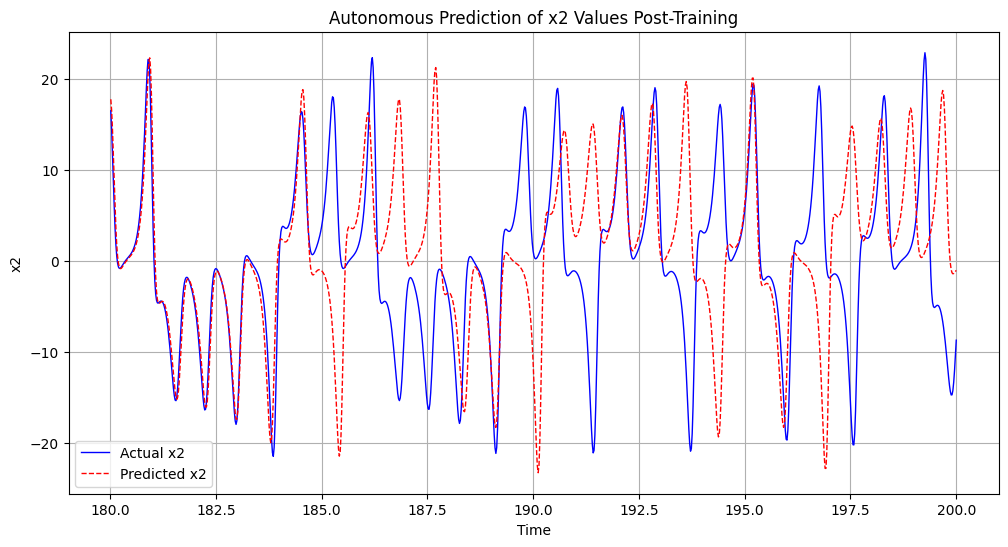

In [23]:
# Define training and prediction intervals
train_size = int(len(x2) * 0.9)
test_size = len(x2) - train_size  # Remaining for testing

# Parameters for the reservoir
num_neurons = 500
input_scaling = 0.1
reservoir_scaling = 0.95

# Initialize weights
input_weights = random.randn(num_neurons, 1) * input_scaling
reservoir_weights = random.randn(num_neurons, num_neurons)
reservoir_weights *= reservoir_scaling / max(abs(np.linalg.eigvals(reservoir_weights)))

# Reservoir state initialization
reservoir_states = np.zeros((num_neurons, len(x2)))

# Train the reservoir on the training data
for t in range(1, train_size):
    input_term = np.dot(input_weights, x2[t-1]).flatten()
    reservoir_term = np.dot(reservoir_weights, reservoir_states[:, t-1])
    reservoir_states[:, t] = tanh(reservoir_term + input_term)

# Fit the output weights using ridge regression
output_weights = Ridge(alpha=1e-5).fit(reservoir_states[:, :train_size].T, x2[:train_size]).coef_

# Predict using trained weights
predicted = np.zeros(test_size)
reservoir_states_test = reservoir_states[:, train_size-1]  # Initial state for prediction

# The initial predicted value should ideally come from the model based on the last training state
predicted[0] = np.dot(output_weights, reservoir_states_test)

for i in range(1, test_size):
    input_term = np.dot(input_weights, predicted[i-1]).flatten()  # use last predicted value
    reservoir_term = np.dot(reservoir_weights, reservoir_states_test)
    reservoir_states_test = tanh(reservoir_term + input_term)
    predicted[i] = np.dot(output_weights, reservoir_states_test)

# Plot results with corrected predictions
plt.figure(figsize=(12, 6))
plt.plot(t_eval[train_size:train_size + test_size], x2[train_size:train_size + test_size], label='Actual x2', color='blue', linewidth=1)
plt.plot(t_eval[train_size:train_size + test_size], predicted, label='Predicted x2', color='red', linestyle='--', linewidth=1)
plt.title('Autonomous Prediction of x2 Values Post-Training')
plt.xlabel('Time')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


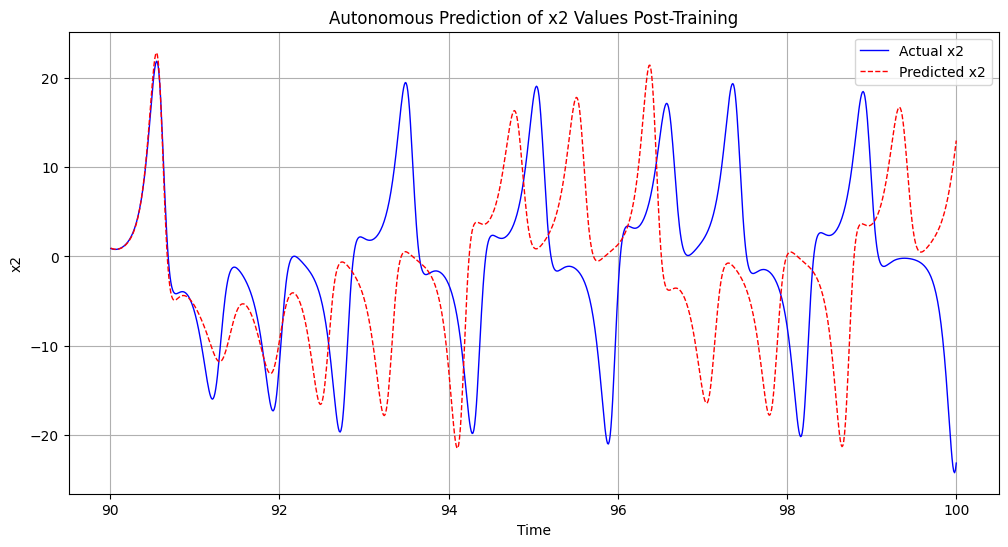

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from numpy import random, tanh

# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x1, x2, x3 = y
    return [-sigma * (x1 - x2), x1 * (rho - x3) - x2, x1 * x2 - beta * x3]

# Solve the Lorenz system
def solve_lorenz(y0, t_span, t_eval):
    sol = solve_ivp(lorenz_system, t_span, y0, t_eval=t_eval)
    return sol.y

# Initialize the reservoir
def initialize_reservoir(num_neurons, input_scaling, reservoir_scaling):
    input_weights = random.randn(num_neurons, 1) * input_scaling
    reservoir_weights = random.randn(num_neurons, num_neurons)
    reservoir_weights *= reservoir_scaling / max(abs(np.linalg.eigvals(reservoir_weights)))
    return input_weights, reservoir_weights

# Train the reservoir
def train_reservoir(x2, num_neurons, input_weights, reservoir_weights, train_size):
    reservoir_states = np.zeros((num_neurons, len(x2)))
    for t in range(1, train_size):
        input_term = np.dot(input_weights, x2[t-1]).flatten()
        reservoir_term = np.dot(reservoir_weights, reservoir_states[:, t-1])
        reservoir_states[:, t] = tanh(reservoir_term + input_term)
    return reservoir_states

# Fit the output weights
def fit_output_weights(reservoir_states, x2, train_size, alpha=1e-5):
    ridge = Ridge(alpha=alpha)
    ridge.fit(reservoir_states[:, :train_size].T, x2[:train_size])
    return ridge.coef_

# Predict using the reservoir
def predict_reservoir(test_size, train_size, x2, input_weights, reservoir_weights, output_weights, reservoir_states):
    predicted = np.zeros(test_size)
    reservoir_states_test = reservoir_states[:, train_size-1]
    predicted[0] = np.dot(output_weights, reservoir_states_test)
    for i in range(1, test_size):
        input_term = np.dot(input_weights, predicted[i-1]).flatten()
        reservoir_term = np.dot(reservoir_weights, reservoir_states_test)
        reservoir_states_test = tanh(reservoir_term + input_term)
        predicted[i] = np.dot(output_weights, reservoir_states_test)
    return predicted

# Plot results
def plot_results(t_eval, x2, predicted, train_size, test_size):
    plt.figure(figsize=(12, 6))
    plt.plot(t_eval[train_size:train_size + test_size], x2[train_size:train_size + test_size], label='Actual x2', color='blue', linewidth=1)
    plt.plot(t_eval[train_size:train_size + test_size], predicted, label='Predicted x2', color='red', linestyle='--', linewidth=1)
    plt.title('Autonomous Prediction of x2 Values Post-Training')
    plt.xlabel('Time')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()

def RunRC(train_data, test_data, t_eval, num_neurons=500, input_scaling=0.1, reservoir_scaling=0.95, alpha=1e-5):
    x2 = np.concatenate((train_data, test_data))
    train_size = len(train_data)
    test_size = len(test_data)

    # Initialize weights
    input_weights, reservoir_weights = initialize_reservoir(num_neurons, input_scaling, reservoir_scaling)

    # Train the reservoir on the training data
    reservoir_states = train_reservoir(x2, num_neurons, input_weights, reservoir_weights, train_size)

    # Fit the output weights using ridge regression
    output_weights = fit_output_weights(reservoir_states, x2, train_size, alpha)

    # Predict using trained weights
    predicted = predict_reservoir(test_size, train_size, x2, input_weights, reservoir_weights, output_weights, reservoir_states)

    # Plot results with corrected predictions
    plot_results(t_eval, x2, predicted, train_size, test_size)

# Initial conditions and time span for the Lorenz system
y0 = [1.0, 1.0, 1.0]
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solving the system
x2 = solve_lorenz(y0, t_span, t_eval)[1]

# Define training and prediction intervals
train_size = int(len(x2) * 0.9)
train_data = x2[:train_size]
test_data = x2[train_size:]

# Run the reservoir computing
RunRC(train_data, test_data, t_eval)


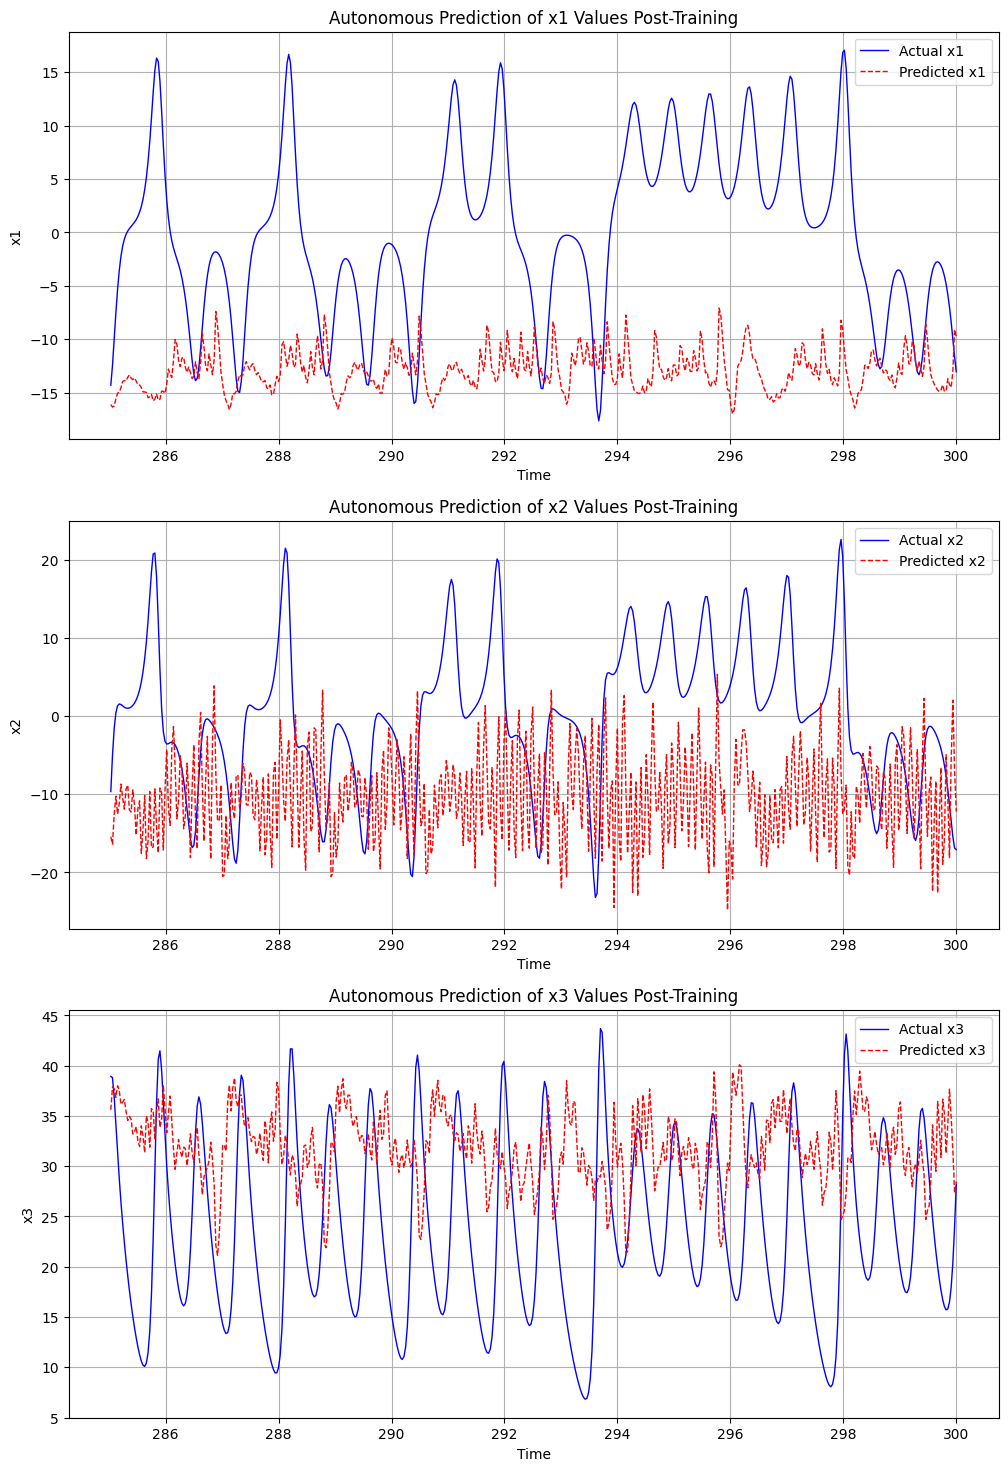

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from numpy import random, tanh

# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x1, x2, x3 = y
    return [-sigma * (x1 - x2), x1 * (rho - x3) - x2, x1 * x2 - beta * x3]

# Solve the Lorenz system
def solve_lorenz(y0, t_span, t_eval):
    sol = solve_ivp(lorenz_system, t_span, y0, t_eval=t_eval)
    return sol.y

# Initialize the reservoir
def initialize_reservoir(num_neurons, input_scaling, reservoir_scaling):
    input_weights = random.randn(num_neurons, 3) * input_scaling  # 3 inputs for x1, x2, x3
    reservoir_weights = random.randn(num_neurons, num_neurons)
    reservoir_weights *= reservoir_scaling / max(abs(np.linalg.eigvals(reservoir_weights)))
    return input_weights, reservoir_weights

# Train the reservoir
def train_reservoir(data, num_neurons, input_weights, reservoir_weights, train_size):
    reservoir_states = np.zeros((num_neurons, train_size))
    for t in range(1, train_size):
        input_term = np.dot(input_weights, data[:, t-1])
        reservoir_term = np.dot(reservoir_weights, reservoir_states[:, t-1])
        reservoir_states[:, t] = tanh(reservoir_term + input_term)
    return reservoir_states

# Fit the output weights
def fit_output_weights(reservoir_states, data, train_size, alpha=1e-5):
    ridge = Ridge(alpha=alpha)
    ridge.fit(reservoir_states[:, :train_size].T, data[:, :train_size].T)
    return ridge.coef_

# Predict using the reservoir
def predict_reservoir(test_size, train_size, input_weights, reservoir_weights, output_weights, reservoir_states):
    predicted = np.zeros((3, test_size))  # 3 outputs for x1, x2, x3
    reservoir_states_test = reservoir_states[:, train_size-1]
    predicted[:, 0] = np.dot(output_weights, reservoir_states_test)
    for i in range(1, test_size):
        input_term = np.dot(input_weights, predicted[:, i-1])
        reservoir_term = np.dot(reservoir_weights, reservoir_states_test)
        reservoir_states_test = tanh(reservoir_term + input_term)
        predicted[:, i] = np.dot(output_weights, reservoir_states_test)
    return predicted

# Plot results
def plot_results(t_eval, data, predicted, train_size, test_size):
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    titles = ['x1', 'x2', 'x3']
    for i in range(3):
        axes[i].plot(t_eval[train_size:train_size + test_size], data[i, train_size:train_size + test_size], label=f'Actual {titles[i]}', color='blue', linewidth=1)
        axes[i].plot(t_eval[train_size:train_size + test_size], predicted[i], label=f'Predicted {titles[i]}', color='red', linestyle='--', linewidth=1)
        axes[i].set_title(f'Autonomous Prediction of {titles[i]} Values Post-Training')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(titles[i])
        axes[i].legend()
        axes[i].grid(True)
    plt.show()

def RunRC(train_data, test_data, t_eval, num_neurons=500, input_scaling=0.1, reservoir_scaling=0.95, alpha=1e-5):
    data = np.concatenate((train_data, test_data), axis=1)
    train_size = train_data.shape[1]
    test_size = test_data.shape[1]

    # Initialize weights
    input_weights, reservoir_weights = initialize_reservoir(num_neurons, input_scaling, reservoir_scaling)

    # Train the reservoir on the training data
    reservoir_states = train_reservoir(data, num_neurons, input_weights, reservoir_weights, train_size)

    # Fit the output weights using ridge regression
    output_weights = fit_output_weights(reservoir_states, data, train_size, alpha)

    # Predict using trained weights
    predicted = predict_reservoir(test_size, train_size, input_weights, reservoir_weights, output_weights, reservoir_states)

    # Plot results with corrected predictions
    plot_results(t_eval, data, predicted, train_size, test_size)

# Initial conditions and time span for the Lorenz system
y0 = [1.0, 1.0, 1.0]
t_span = [0, 300]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solving the system
data = solve_lorenz(y0, t_span, t_eval)

# Define training and prediction intervals
train_size = int(data.shape[1] * 0.95)
train_data = data[:, :train_size]
test_data = data[:, train_size:]

# Run the reservoir computing
RunRC(train_data, test_data, t_eval)
